<a href="https://colab.research.google.com/github/WenluXu/Data-Science-Bootcamp-2022/blob/main/Week6_ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import collections
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

**We Start by Loading the dataset and loading the head to have a sparse view of the data**

In [ ]:
df=pd.read_csv('train.csv')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A22,A23,A24,A25,A26,A27,A28,A29,A30,default
0,10.69,86.10,8920.16,19912.85,30.42,31.72,1.18,145.41,2.236,1.786,...,0.01,0.01,0.01,0.13,0.00,0.00,0.00,0.00,0.00,0
1,28.50,65.19,6564.00,6716.67,32.50,23.40,2.74,91.11,1.000,1.000,...,0.06,0.01,0.00,0.09,285.80,0.00,16.44,1.98,42.26,0
2,24.87,73.79,4285.47,6463.75,40.50,51.53,2.84,93.90,2.400,1.400,...,0.08,0.02,0.02,0.44,494.62,135.41,127.45,46.00,14.92,0
3,13.64,85.82,6887.56,9244.44,49.56,53.44,0.36,171.45,1.875,2.167,...,0.03,0.01,0.00,0.05,1015.19,0.00,210.63,92.58,0.00,0
4,4.50,95.92,8746.50,19987.50,32.75,37.88,0.92,153.25,2.000,1.500,...,0.01,0.00,0.00,0.04,0.00,106.41,79.00,0.00,0.00,0


From the above we can see the data is purely numerical and no catogorical data is present

### Exploratory Data Analysis

Since the data is purely numerical we look the dataset is balanced or not

In [ ]:
len(df)

94000

In [ ]:
df['default'].value_counts()

0    90000
1     4000
Name: default, dtype: int64

Looking to the labels we can see that its is a binary classification problem.
Also it can be seen that the data is highly imbalaced since the label "0" is present for 90k instances while label"1" is present for 4k instances only

#### Outlier Detection

In [ ]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])

    # compute IRQ
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]

    return outliers

We check shape i.e (number of training samples and the no. of features )

In [ ]:
df.shape

(94000, 31)

We now check if our dataset consists of null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94000 entries, 0 to 93999
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   A1       94000 non-null  float64
 1   A2       94000 non-null  float64
 2   A3       94000 non-null  float64
 3   A4       94000 non-null  float64
 4   A5       94000 non-null  float64
 5   A6       94000 non-null  float64
 6   A7       94000 non-null  float64
 7   A8       94000 non-null  float64
 8   A9       94000 non-null  float64
 9   A10      94000 non-null  float64
 10  A11      94000 non-null  float64
 11  A12      94000 non-null  float64
 12  A13      94000 non-null  float64
 13  A14      94000 non-null  float64
 14  A15      94000 non-null  float64
 15  A16      94000 non-null  float64
 16  A17      94000 non-null  float64
 17  A18      94000 non-null  float64
 18  A19      94000 non-null  float64
 19  A20      94000 non-null  float64
 20  A21      94000 non-null  int64  
 21  A22      940

We can see that data doesnt have any null values .hence we dont ahve to impute any values

In [ ]:
df.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A22,A23,A24,A25,A26,A27,A28,A29,A30,default
count,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,...,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000,94000.000000
mean,12.134211,83.838361,7319.620881,13449.501569,33.507640,36.983300,1.518232,124.108845,1.697824,1.407075,...,0.074435,0.008550,0.013537,0.133531,290.756534,357.976444,103.482568,28.847016,38.509910,0.042553
std,6.587858,8.672843,2652.539364,8197.452662,11.906865,14.209314,1.007398,33.130292,0.776810,0.652138,...,0.138356,0.020052,0.029078,0.156658,471.958770,597.594147,136.248095,62.759062,90.882963,0.201849
min,0.000000,20.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.010000,-0.020000,-0.020000,0.000000,-751.260000,-405.370000,-616.230000,-490.160000,-719.720000,0.000000
25%,7.670000,79.000000,5618.627500,8700.000000,26.880000,28.780000,0.820000,103.027500,1.272000,1.000000,...,0.010000,0.000000,0.000000,0.060000,0.000000,0.000000,14.970000,0.000000,0.000000,0.000000
50%,12.020000,84.360000,7285.590000,11862.650000,32.770000,35.940000,1.420000,127.240000,1.667000,1.399000,...,0.030000,0.000000,0.010000,0.090000,115.140000,102.265000,59.350000,10.500000,0.000000,0.000000
75%,16.080000,89.670000,8780.870000,15896.575000,39.100000,43.830000,2.020000,143.100000,2.064000,1.714000,...,0.080000,0.010000,0.010000,0.140000,380.142500,485.880000,140.952500,34.860000,49.862500,0.000000
max,62.710000,100.000000,26333.500000,170300.000000,146.000000,146.000000,18.670000,524.000000,44.000000,44.000000,...,5.300000,0.700000,1.690000,4.080000,15288.660000,19503.760000,3265.980000,6561.930000,13487.000000,1.000000


In [ ]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A22,A23,A24,A25,A26,A27,A28,A29,A30,default
0,10.69,86.10,8920.16,19912.85,30.42,31.72,1.18,145.41,2.236,1.786,...,0.01,0.01,0.01,0.13,0.00,0.00,0.00,0.00,0.00,0
1,28.50,65.19,6564.00,6716.67,32.50,23.40,2.74,91.11,1.000,1.000,...,0.06,0.01,0.00,0.09,285.80,0.00,16.44,1.98,42.26,0
2,24.87,73.79,4285.47,6463.75,40.50,51.53,2.84,93.90,2.400,1.400,...,0.08,0.02,0.02,0.44,494.62,135.41,127.45,46.00,14.92,0
3,13.64,85.82,6887.56,9244.44,49.56,53.44,0.36,171.45,1.875,2.167,...,0.03,0.01,0.00,0.05,1015.19,0.00,210.63,92.58,0.00,0
4,4.50,95.92,8746.50,19987.50,32.75,37.88,0.92,153.25,2.000,1.500,...,0.01,0.00,0.00,0.04,0.00,106.41,79.00,0.00,0.00,0


In [ ]:
df.isin([0]).sum(axis=0)

A1          2326
A2             0
A3            51
A4            13
A5            31
A6            88
A7          2138
A8            14
A9          3395
A10         4229
A11           42
A12            0
A13          777
A14           10
A15            5
A16        12955
A17          103
A18        18048
A19        27345
A20           58
A21            0
A22         7431
A23        56456
A24        40504
A25          147
A26        28318
A27        35410
A28        13539
A29        23649
A30        51494
default    90000
dtype: int64

### Data Visualization

We first plot the boxplot of each feature with the output label to see its distribution across both
 th elabels . Its median values and its distributuin of th eoutliers if any

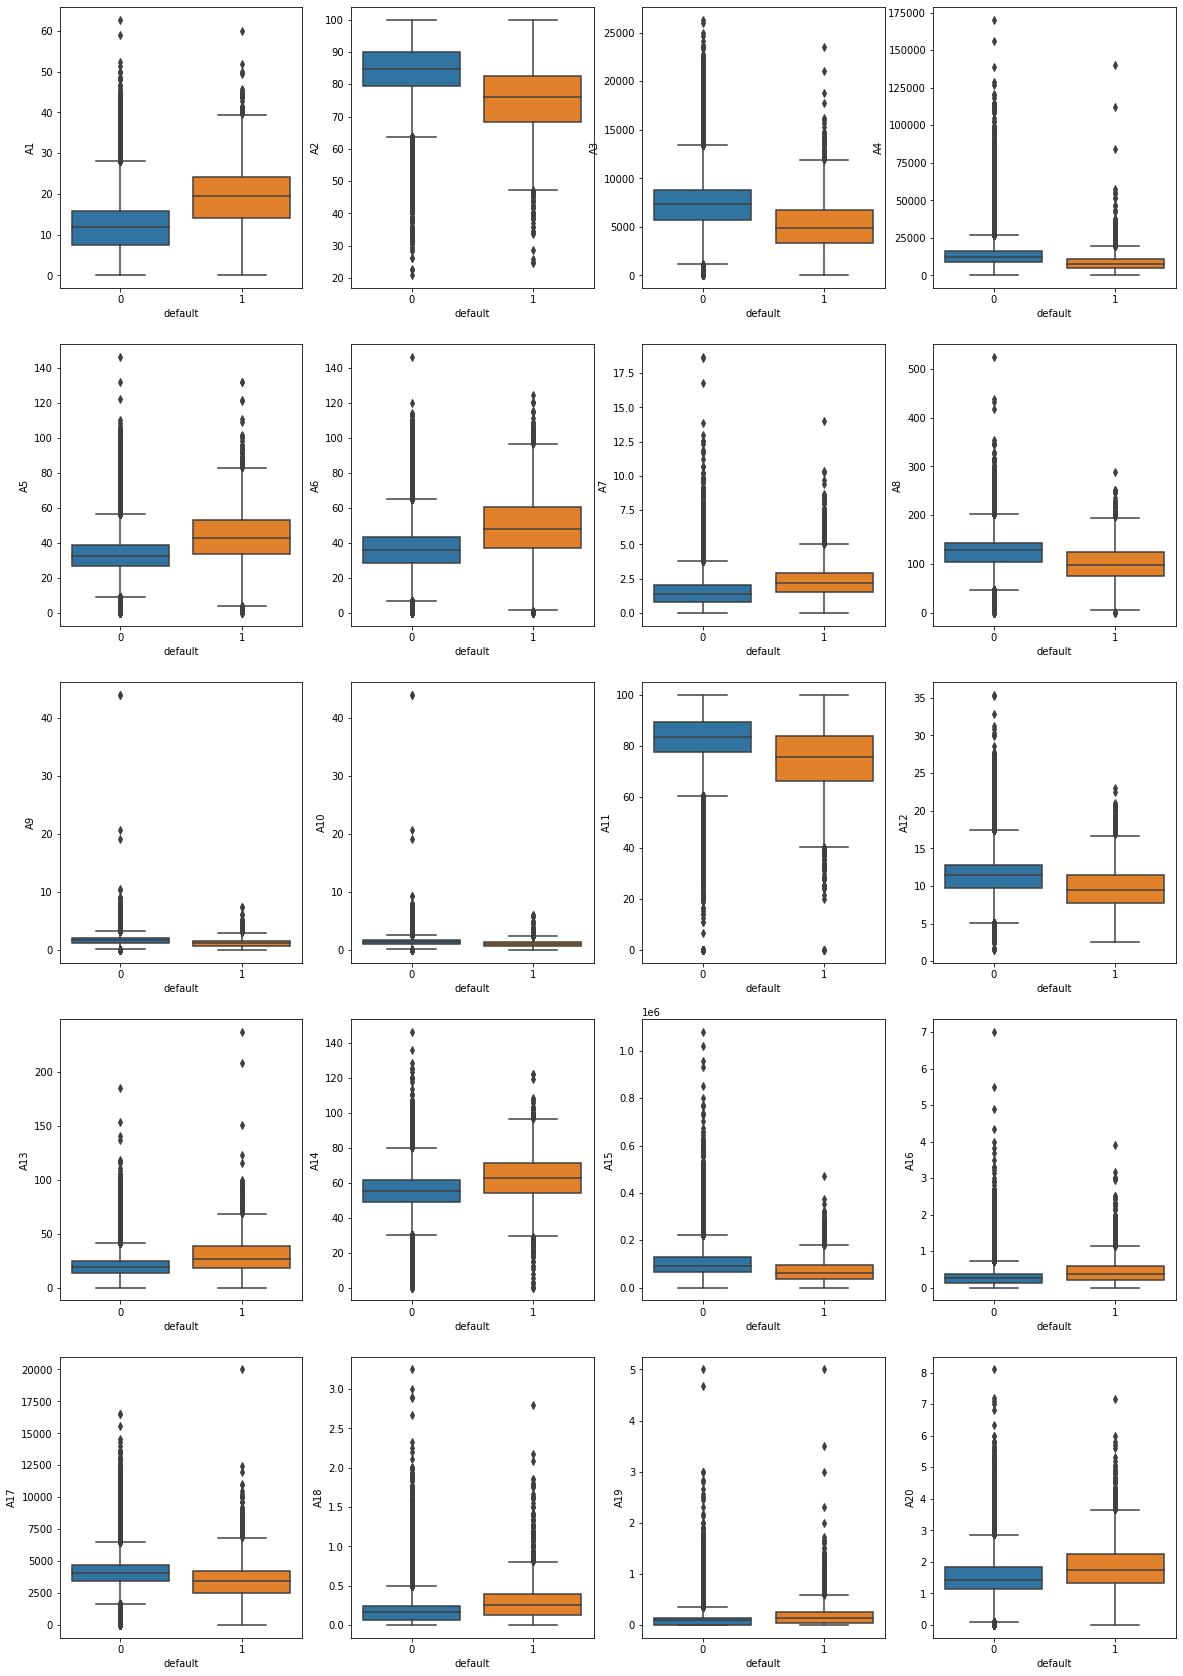

In [ ]:
df_X = df.drop(columns=['default'])
df_y = df['default']
fig, ax = plt.subplots(5, 4, figsize = (20,30))
for col, subplot in zip(df_X.columns, ax.flatten()):
    sns.boxplot(y = col, x =df_y, data = df_X, ax= subplot)

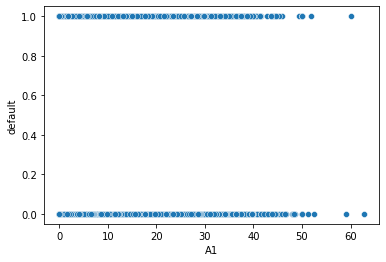

In [ ]:
sns.scatterplot(x='A1', y='default', data=df)

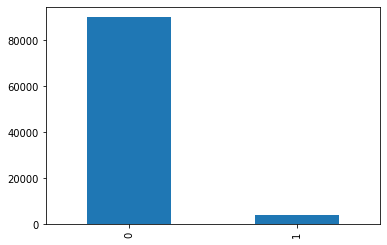

In [ ]:
df['default'].value_counts().sort_index().plot.bar()

**We  now check feature correalation to see if there are any existing correlation in between features using heatmap**

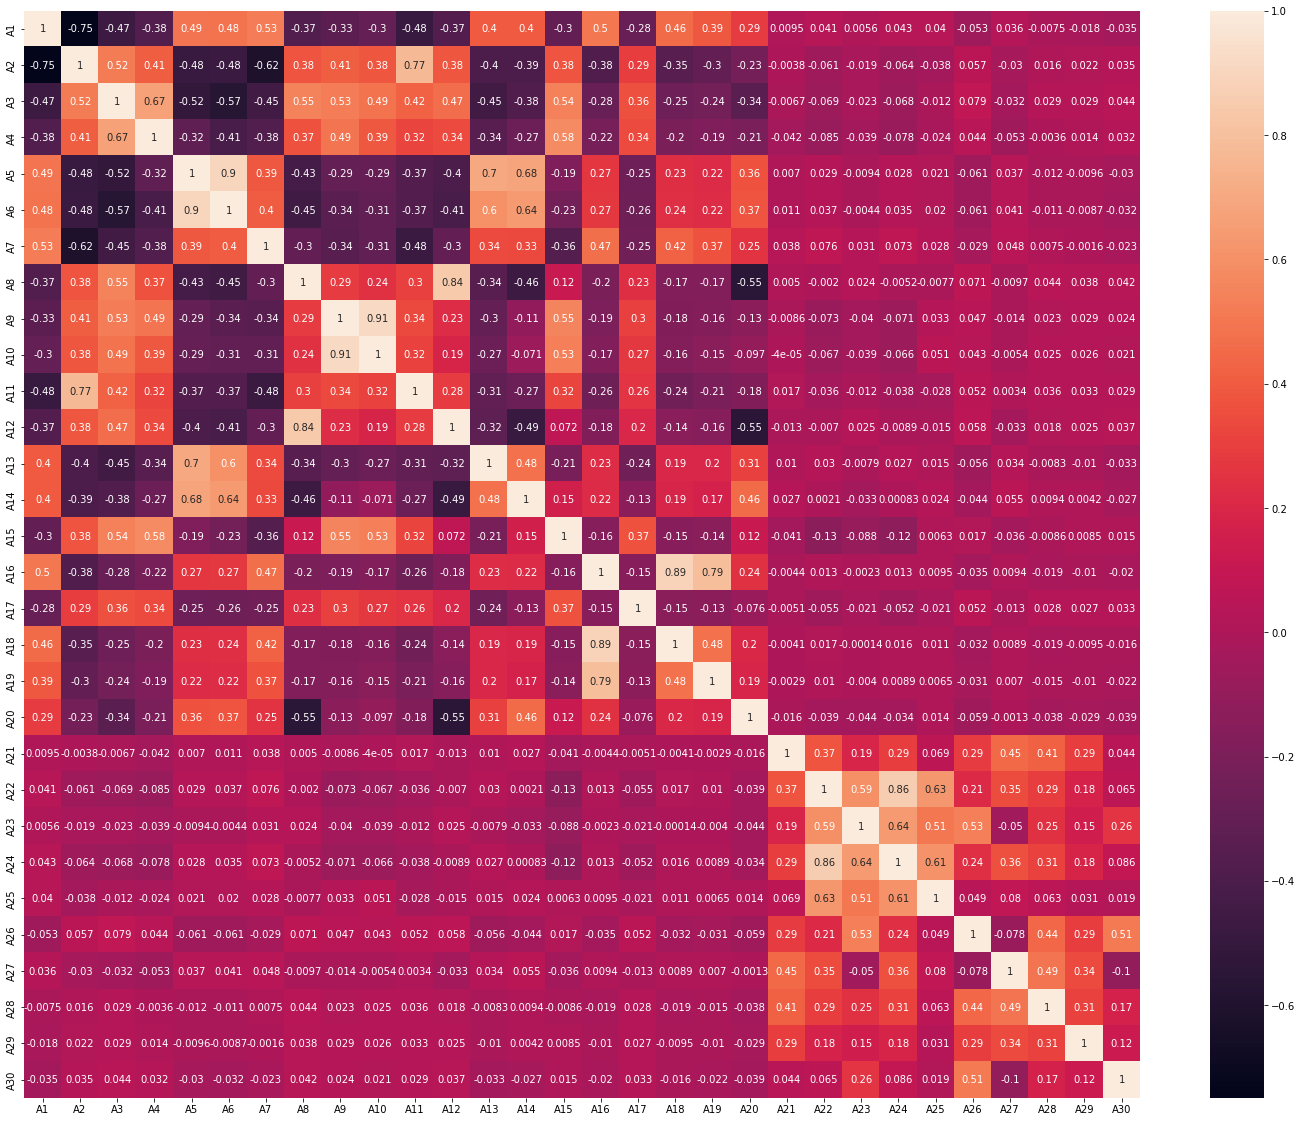

In [ ]:
plt.figure(figsize = (25, 20))
sns.heatmap(df_X.corr(), annot = True)
plt.show()

From the above heatmap we can see that there exist some correlation between features that follows
We can see that there is strong correaltion between (A6 and A5), (A10 and A9), (A12 and A8), (A18 and A16), (A19 and A16)

#### WE now try to compute the feature importance of Dataset  to find which feature to be counted for training model and reduce dimensionality of opur model without affecting the model performance/ accuracy

In [ ]:
df.shape

(94000, 31)

We fisrt start with training the whole dataset using Random Forest classifer

To do so we first normalise the datasetby using Standard Scalar Library so that we have all the features on same scale and helps the model to converge quickly

In [ ]:
#Using the Scaler function  library
train_X = df.loc[:, df.columns != 'default']
train_y = df['default']
num_col = df_X.columns.to_list()
num_col = num_col[:-1]
scaler = StandardScaler()
scaler.fit(df_X[num_col])
train_X[num_col] = scaler.transform(df_X[num_col])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
train_X.shape

(94000, 30)

In [ ]:
train_X.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30
0,-0.219224,0.260774,0.603402,0.788462,-0.259317,-0.370414,-0.335750,0.642954,0.692807,0.581053,...,-0.771969,-0.465717,0.072313,-0.121634,-0.022540,-0.616067,-0.599033,-0.759520,-0.459649,0.00
1,2.484249,-2.150213,-0.284868,-0.821337,-0.084627,-0.955948,1.212802,-0.996038,-0.898325,-0.624220,...,-0.330411,-0.104329,0.072313,-0.465544,-0.277875,-0.010502,-0.599033,-0.638857,-0.428100,42.26
2,1.933232,-1.158607,-1.143873,-0.852190,0.587258,1.023749,1.312068,-0.911824,0.903928,-0.010850,...,-0.401060,0.040225,0.571023,0.222275,1.956309,0.431954,-0.372439,0.175911,0.273316,14.92
3,0.228572,0.228489,-0.162887,-0.512974,1.348167,1.158169,-1.149733,1.428946,0.228083,1.165289,...,-0.436385,-0.321162,0.072313,-0.465544,-0.533211,1.534959,-0.599033,0.786418,1.015524,0.00
4,-1.158837,1.393050,0.537932,0.797569,-0.063631,0.063107,-0.593842,0.879597,0.388999,0.142493,...,-0.560021,-0.465717,-0.426397,-0.465544,-0.597045,-0.616067,-0.420968,-0.179692,-0.459649,0.00


In [ ]:
train_y.head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: int64

In [ ]:
# #Y= train_data['default']
# #X = train_data.drop(columns=['default'], axis=1)
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(train_X.shape)
print(train_y.shape)

(94000, 30)
(94000,)


In [ ]:
num_col= train_X.columns.to_list()
scaler = StandardScaler()
scaler.fit(train_X[num_col])
train_X[num_col] = scaler.transform(train_X[num_col])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
forest = RandomForestClassifier()
forest.fit(train_X, train_y)
print(train_X.shape)

(94000, 30)


We now plt the feature importances to select the most important features

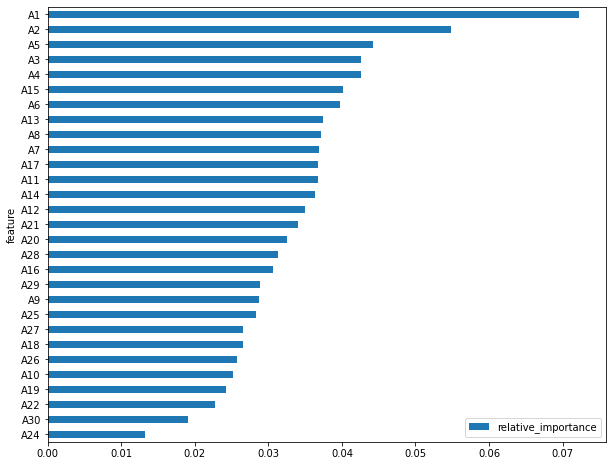

In [ ]:
feature_imp=pd.DataFrame()
for feature,imp in zip(train_X.columns, forest.feature_importances_):
    temp=pd.DataFrame([feature,imp]).T
    feature_imp=feature_imp.append(temp)
feature_imp.columns=['feature','relative_importance']
feature_imp.sort_values(by='relative_importance',inplace=True)
feature_imp.set_index('feature',inplace=True)
feature_imp.iloc[-29:,:].plot(kind='barh',figsize=(10,8))
plt.show()

In [ ]:
feature_list = feature_imp["relative_importance"].to_list()
print((feature_list))

[0.009851910651232379, 0.01322670141750888, 0.01911904009270109, 0.022686691186274466, 0.024205345766743627, 0.025171842265659636, 0.025669389809120414, 0.02652282352732948, 0.026528268422704195, 0.028377426669462243, 0.028696048952359013, 0.028896494990796575, 0.030636051348934316, 0.03128004891089233, 0.03259396497511654, 0.03399215091460674, 0.035008766123629194, 0.03628754114426348, 0.03676989491616836, 0.036779651312431196, 0.03685597092863804, 0.037155054088907305, 0.03735806729991791, 0.039742723322372595, 0.0401439515662752, 0.0425632013205699, 0.042648986062983514, 0.04418352102672628, 0.05477026746866483, 0.07227820351701045]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

lr = LogisticRegression()
lr.fit(train_X, train_y)
accuracy_score(Y_test, lr.predict(X_test))

0.9601063829787234

In [ ]:
# 90000 for 0 and 4000 instance for 1

# for train we have(81000 for 0 and 3600 instance for 1)

# for test we have (5000 for 0 it predicts all as 0 and 5000 instance for 1 it also predicts as 0)

total_correct = 5000
total_instance = 10000

accuracy = total_correct/total_instance
accuracy

0.5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


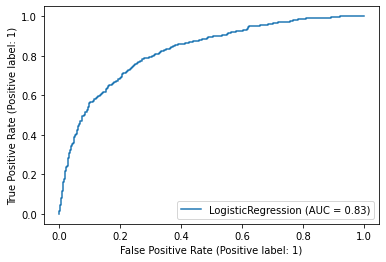

In [ ]:
from sklearn import metrics
metrics.plot_roc_curve(lr, X_test, Y_test)

In [ ]:
f1_score(Y_test, lr.predict(X_test), average='weighted')

0.9424806270765145

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(train_X, train_y)
accuracy_score(Y_test, knn.predict(X_test))

0.9612765957446808

In [ ]:
f1_score(Y_test, knn.predict(X_test), average='weighted')

0.9438860977255408

In [ ]:
sorted_feature = feature_imp.sort_values(["relative_importance"], ascending=False)
print(sorted_feature)

        relative_importance
feature                    
A1                 0.072278
A2                  0.05477
A5                 0.044184
A3                 0.042649
A4                 0.042563
A15                0.040144
A6                 0.039743
A13                0.037358
A8                 0.037155
A7                 0.036856
A17                 0.03678
A11                 0.03677
A14                0.036288
A12                0.035009
A21                0.033992
A20                0.032594
A28                 0.03128
A16                0.030636
A29                0.028896
A9                 0.028696
A25                0.028377
A27                0.026528
A18                0.026523
A26                0.025669
A10                0.025172
A19                0.024205
A22                0.022687
A30                0.019119
A24                0.013227
A23                0.009852


We now sort the features according to its relative importance to experiment with the 60% of the top features

In [ ]:
sorted_top = sorted_feature.index.to_list()
print(sorted_top)

['A1', 'A2', 'A5', 'A3', 'A4', 'A15', 'A6', 'A13', 'A8', 'A7', 'A17', 'A11', 'A14', 'A12', 'A21', 'A20', 'A28', 'A16', 'A29', 'A9', 'A25', 'A27', 'A18', 'A26', 'A10', 'A19', 'A22', 'A30', 'A24', 'A23']


In [ ]:
sorted_top = sorted_top[:16]
print(sorted_top)

['A1', 'A2', 'A5', 'A3', 'A4', 'A15', 'A6', 'A13', 'A8', 'A7', 'A17', 'A11', 'A14', 'A12', 'A21', 'A20']


We now look at the following top features and remove the correlated features found from the above plotted heatmap

We can see A6 and A5 were correleated, A8 and A12 are correleated still present in the important feature list
. Hence we remove theA6 and A12 columns from feature list since they seem to have less importance as there correleted feature

In [ ]:
sorted_top.remove("A6")
sorted_top.remove("A12")

In [ ]:
print(sorted_top)

['A1', 'A2', 'A5', 'A3', 'A4', 'A15', 'A13', 'A8', 'A7', 'A17', 'A11', 'A14', 'A21', 'A20']


We now train the model using the following columns

## Training and Testing

In [ ]:
train_X = df.copy()
train_X = train_X[sorted_top]
train_y = df['default']

In [ ]:
print(train_X.shape)

(94000, 14)


In [ ]:
num_col= train_X.columns.to_list()
scaler = StandardScaler()
scaler.fit(train_X[num_col])
train_X[num_col] = scaler.transform(train_X[num_col])

In [ ]:
print(train_X.shape)

(94000, 14)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_y, test_size=0.1, random_state=41)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(84600, 14)
(9400, 14)
(84600,)
(9400,)


While using logistic regression may work well but since the dataset is highly imbalanced we also changes its class weight parameter so we can have weighted loss for the different labels i.e

**higher loss for rare classes**

**reduce loss for abundant classes**

In [ ]:
lr1 = LogisticRegression(solver="newton-cg", class_weight={0: 0.15, 1: 0.85})
lr1.fit(X_train, Y_train)
accuracy_score(Y_test, lr1.predict(X_test))

0.9278723404255319

In [ ]:
f1_score(Y_test, lr1.predict(X_test), average='weighted')

0.9328433568668477

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


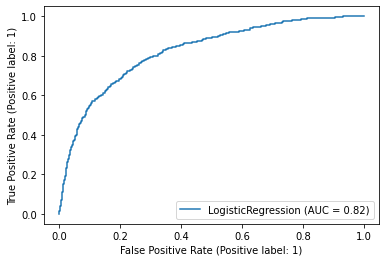

In [ ]:
metrics.plot_roc_curve(lr1, X_test, Y_test)

**KNN would be 2nd choice for the model since KNN performs really well for numeric values**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, Y_train)
accuracy_score(Y_test, knn.predict(X_test))

0.9543617021276596

In [ ]:
f1_score(Y_test, knn.predict(X_test), average='weighted')

0.9357267736588664

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


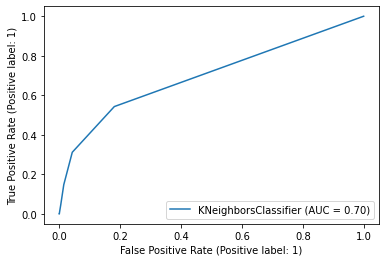

In [ ]:
metrics.plot_roc_curve(knn, X_test, Y_test)

In [ ]:
randforst1 = RandomForestClassifier()
randforst1.fit(X_train, Y_train)
accuracy_score(Y_test, randforst1.predict(X_test))

0.9601063829787234

In [ ]:
f1_score(Y_test, randforst1.predict(X_test), average='weighted')

0.9418954942377684

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


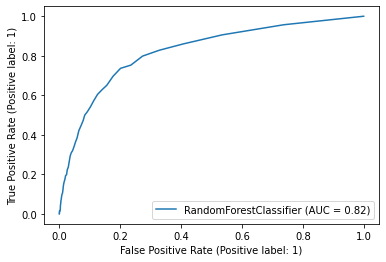

In [ ]:
metrics.plot_roc_curve(randforst1, X_test, Y_test)

WE now start the model prediction on validation set

In [ ]:
val_data = pd.read_csv("test.csv")

In [ ]:
val_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A22,A23,A24,A25,A26,A27,A28,A29,A30,default
0,22.88,75.59,3367.08,6131.31,41.38,43.08,2.13,102.67,0.500,0.500,...,0.08,0.00,0.05,0.17,0.00,1035.14,158.71,13.28,0.00,1
1,15.94,86.26,5595.00,10867.86,52.29,61.21,3.05,124.94,3.200,2.400,...,0.01,0.00,0.00,0.06,438.50,0.00,72.78,44.88,25.39,1
2,25.16,64.20,4758.44,7818.15,46.28,50.72,2.69,110.16,1.124,0.889,...,0.08,0.02,0.02,0.10,622.70,755.52,102.89,6.24,0.00,1
3,19.50,77.81,5762.27,6290.00,58.14,76.27,2.44,119.92,1.222,1.000,...,0.04,0.00,0.01,0.08,197.55,396.27,76.34,8.44,2.00,1
4,11.11,85.09,11400.50,20936.25,30.00,29.75,0.50,125.89,2.167,1.333,...,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,1


In [ ]:
valX = val_data[sorted_top]
valX.head()

,A1,A2,A4,A3,A5,A15,A11,A13,A14,A17,A8,A7,A20,A21
0,22.88,75.59,6131.31,3367.08,41.38,42131.54,75.85,22.22,58.46,4005.22,102.67,2.13,1.25,28
1,15.94,86.26,10867.86,5595.00,52.29,148530.21,75.00,15.73,63.36,2281.82,124.94,3.05,2.37,64
2,25.16,64.20,7818.15,4758.44,46.28,39652.58,62.57,32.24,62.83,3050.54,110.16,2.69,1.51,55
3,19.50,77.81,6290.00,5762.27,58.14,86341.79,82.50,48.73,66.29,4169.09,119.92,2.44,2.69,283
4,11.11,85.09,20936.25,11400.50,30.00,224497.30,95.86,37.20,63.30,8970.00,125.89,0.50,1.25,26


In [ ]:
valX.shape

(11500, 14)

In [ ]:
num_col = valX.columns.to_list()
scaler = StandardScaler()
scaler.fit(valX)
valX[num_col] = scaler.transform(valX)

print(valX)

             A1        A2        A4        A3        A5       A15       A11  \
0      1.416868 -0.821378 -0.859076 -1.404295  0.545734 -1.012080 -0.537477   
1      0.430368  0.361961 -0.264063 -0.570900  1.419649  0.825169 -0.614458   
2      1.740963 -2.084567 -0.647173 -0.883831  0.938235 -1.054886 -1.740190   
3      0.936412 -0.575172 -0.839141 -0.508330  1.888247 -0.248675  0.064785   
4     -0.256201  0.232204  1.000744  1.600753 -0.365829  2.136938  1.274744   
...         ...       ...       ...       ...       ...       ...       ...   
11495  0.232784  0.560478  1.969254  0.512951  0.927821  1.698848  0.845462   
11496  0.672018 -0.355584 -0.532739 -0.306038  1.221797 -0.662555 -0.185176   
11497  2.188726 -0.942263 -0.254229 -0.526454  0.287004  1.039840 -1.740190   
11498  0.515657 -0.577391 -1.029458 -1.530868 -0.575697 -0.446738 -0.225025   
11499  0.996113  0.000416 -0.829510 -1.502095  0.790847 -1.225226 -0.031214   

            A13       A14       A17        A8      

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
valY_lr = lr1.predict(valX)

In [ ]:
valY_knn = knn.predict(valX)

In [ ]:
print(type(valY_knn))

<class 'numpy.ndarray'>


In [ ]:
submission_out_lr = pd.DataFrame(valY_lr)
submission_out_lr.to_csv('results1.csv', index=False)

NameError: ignored

In [ ]:
submission_out_knn = pd.DataFrame(valY_knn)
submission_out_knn.to_csv('results2.csv', index=False)

Using the random forest model for getting the feature importance helped significantly in getting the importance features and reducing the dimensionality of our dataset.